In [1]:
import sys
sys.path.append('/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/BasicExample')

import torch
torch.manual_seed(1) 
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from src.weight_distribution.Full import FullCovariance
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 16,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
import matplotlib
from src.network.feature_extractor import FC_Net
from src.network.Classification import LLVIClassification
from src.network import LikApprox, PredictApprox
from datasets.Classification.TwoMoons import create_test_points, create_train_set
from datetime import datetime

In [2]:
n_datapoints=1024
batch_size = 32
x, y = create_train_set(n_datapoints=n_datapoints, noise=0.2)
train_loader = DataLoader(TensorDataset(x, y), batch_size=batch_size)

In [3]:
# data saver
mc_train_losses = []
mc_train_times = []
samples_list = [1,10]

In [4]:
lr = 1e-3
# go over all mc methods
for samples in samples_list:
    print("Starting run", samples)
    torch.manual_seed(5)
    feature_extractor_mc = FC_Net(layers=[2, 20, 20],lr=lr, weight_decay=5e-4, optimizer=torch.optim.Adam, nll=torch.nn.LeakyReLU())
    dist = FullCovariance(20, 2, lr=lr)
    net_mc = LLVIClassification(20, 2, feature_extractor_mc, dist,
    prior_log_var=-1, optimizer_type=torch.optim.Adam,
    tau=1, lr=lr)
    # net_mc.train_without_VI(train_loader, epochs=10)
    start_time = datetime.now()
    train_loss = net_mc.train_model(train_loader, epochs=500, n_datapoints=n_datapoints, samples=samples, method=LikApprox.MONTECARLO)
    total_time = int((datetime.now() - start_time).total_seconds())
    mc_train_losses.append(train_loss)
    mc_train_times.append(total_time)

Starting run 1


prediction_loss:0.07 kl_loss:0.16: 100%|██████████| 500/500 [00:16<00:00, 30.25it/s]


Starting run 10


prediction_loss:0.07 kl_loss:0.16: 100%|██████████| 500/500 [00:16<00:00, 29.73it/s]


In [5]:
approx_list = ["jennsen", "bohning", "multidelta"]
cf_train_losses = []
cf_train_times = []
for approx_name in approx_list:
    print("Starting approx", approx_name)
    lr = 1e-3
    torch.manual_seed(3)
    feature_extractor_cf = FC_Net(layers=[2, 20, 20],lr=lr, weight_decay=5e-4, optimizer=torch.optim.Adam, nll=torch.nn.LeakyReLU())
    dist = FullCovariance(20, 2, lr=lr)
    net_cf = LLVIClassification(20, 2, feature_extractor_cf, dist,
    prior_log_var=-1, optimizer_type=torch.optim.Adam,
    tau=1, lr=lr)
    start_time = datetime.now()
    cf_train_losses.append(net_cf.train_model(train_loader, epochs=500, n_datapoints=n_datapoints, samples=5, method=LikApprox.CLOSEDFORM, approx_name=approx_name))
    cf_train_times.append(int((datetime.now() - start_time).total_seconds()))

Starting approx jennsen


prediction_loss:0.1 kl_loss:0.17: 100%|██████████| 500/500 [00:19<00:00, 26.18it/s] 


Starting approx bohning


prediction_loss:0.09 kl_loss:0.17: 100%|██████████| 500/500 [00:24<00:00, 20.32it/s]


Starting approx multidelta


prediction_loss:0.18 kl_loss:0.16: 100%|██████████| 500/500 [00:23<00:00, 21.41it/s]


In [8]:
mc_train_losses

[    epoch  prediction_loss   kl_loss
 0     0.0         1.195900  0.539688
 0     1.0         0.795694  0.532953
 0     2.0         0.746926  0.526704
 0     3.0         0.502730  0.520878
 0     4.0         0.405327  0.515463
 ..    ...              ...       ...
 0   495.0         0.072454  0.162253
 0   496.0         0.073224  0.162100
 0   497.0         0.073377  0.161947
 0   498.0         0.077486  0.161794
 0   499.0         0.073658  0.161640
 
 [500 rows x 3 columns],
     epoch  prediction_loss   kl_loss
 0     0.0         0.740415  0.540501
 0     1.0         0.580869  0.534444
 0     2.0         0.503681  0.528469
 0     3.0         0.409332  0.522721
 0     4.0         0.367373  0.517249
 ..    ...              ...       ...
 0   495.0         0.070035  0.161999
 0   496.0         0.071409  0.161844
 0   497.0         0.070188  0.161690
 0   498.0         0.070381  0.161536
 0   499.0         0.071213  0.161382
 
 [500 rows x 3 columns]]

Text(0, 0.5, 'Loss')

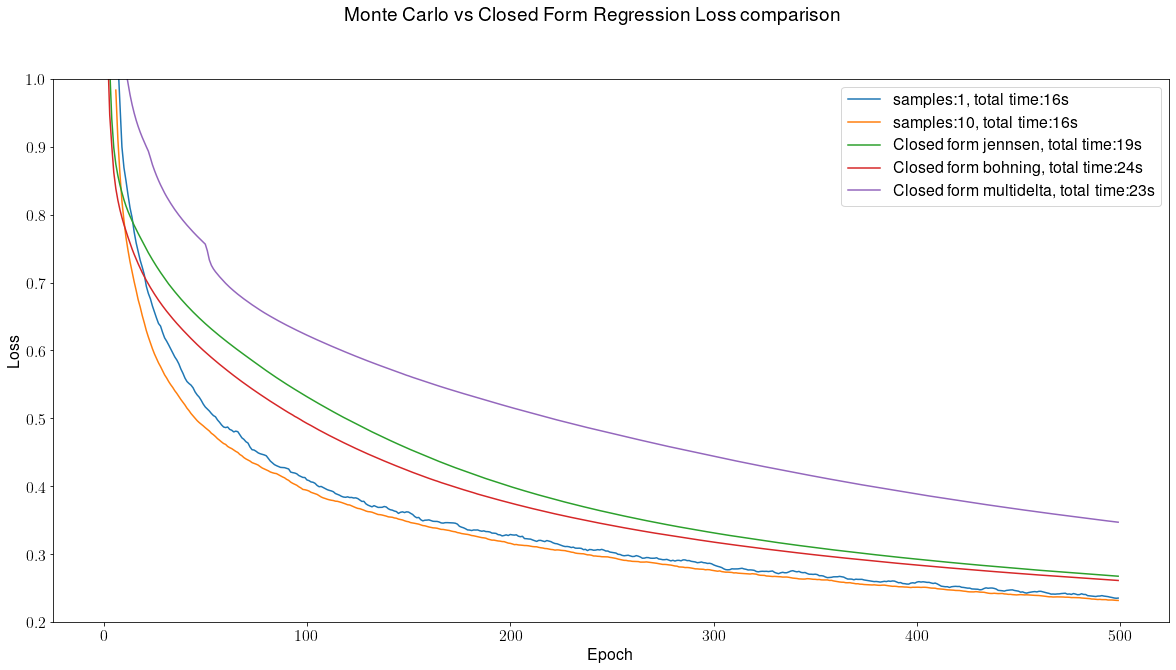

In [10]:
# visualization
fig, ax = plt.subplots(figsize=(20,10))
vi_train_epochs=500
for samples, train_loss, train_time in zip(samples_list, mc_train_losses, mc_train_times):
    # ax.plot(list(range(vi_train_epochs)), train_loss["prediction_loss"], label=f"samples:{samples}, total time:{train_time}s", alpha=0.5)
    # or with smoothing
    ax.plot(list(range(vi_train_epochs)), (train_loss["prediction_loss"] + train_loss["kl_loss"]).rolling(7).mean(), label=f"samples:{samples}, total time:{train_time}s")

for approx_name, train_loss, train_time in zip(approx_list, cf_train_losses, cf_train_times):
    ax.plot(list(range(vi_train_epochs)), (train_loss["prediction_loss"] + train_loss["kl_loss"]), label=f"Closed form {approx_name}, total time:{train_time}s") 

ax.legend()
ax.set_ylim(0.2, 1)
fig.suptitle("Monte Carlo vs Closed Form Regression Loss comparison")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")